# ANALISIS PREDIKSI STOCK MARKET MENGGUNAKAN ARIMA & LSTM
# Tugas Ujian Akhir - Presentasi dan Visualisasi Data

MODEL YANG DIPAKAI:
ARIMA dan LSTM, keduanya punya tujuan yang sama, yakni memprediksi nilai 
masa depan berdasarkan data historis.

**ARIMA (AutoRegressive Integrated Moving Average)**:
- Bekerja dengan asumsi hubungan linear dan stasioneritas
- Cocok untuk data yang memiliki pola trend dan seasonality sederhana
- Komputasi cepat dan interpretable
- Limitasi: Tidak bisa menangkap pola non-linear yang kompleks

**LSTM (Long Short-Term Memory)**:
- Tipe Recurrent Neural Network (RNN) yang mampu menangkap pola non-linear
- Dapat menangani ketergantungan jangka panjang (long-term dependencies)
- Lebih flexible dalam menangkap pola kompleks
- Limitasi: Membutuhkan data yang banyak, komputasi lebih berat, black-box

TUJUAN ANALISIS:
Membandingkan performa ARIMA (statistical) vs LSTM (deep learning) dalam 
memprediksi harga penutupan NYSE Index (NYA) dan menentukan model mana yang 
lebih cocok untuk forecasting stock market.


## Import all libraries needed

In [5]:
%pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 289.0 kB/s eta 0:00:27
   -- ------------------------------------- 0.5/8.1 MB 289.0 kB/s eta 0:00:27
   -- ------------------------------------- 0.5/8.1 MB 289.0 kB/s eta 0:00:27
   -- -

In [6]:
%pip install tensorflow

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.76.0-cp311-cp311-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached h5py-3.15.1-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
Using cached grpcio

In [7]:
# Import semua library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi yang konsisten
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

c:\Users\ASUS\anaconda3\envs\spark\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Load Data & Initial Exploration

In [11]:
# Load data asli (9 kolom: Index, Date, Open, High, Low, Close, Adj Close, Volume, CloseUSD)
df = pd.read_csv('../dataset/indexProcessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Kita pilih Index 'NYA' (New York Stock Exchange) sebagai contoh utama
data = df[df['Index'] == 'NYA'].sort_values('Date').reset_index(drop=True)
data.set_index('Date', inplace=True)

print("="*70)
print("INFORMASI DATASET")
print("="*70)
print(f"Dataset dimuat dengan {data.shape[1]} kolom asli")
print(f"Jumlah records: {len(data)} baris")
print(f"Periode data: {data.index.min().date()} hingga {data.index.max().date()}")
print(f"Total tahun: {(data.index.max() - data.index.min()).days / 365.25:.1f} tahun")
print("\nKolom yang tersedia:")
for i, col in enumerate(data.columns, 1):
    print(f"  {i}. {col}")

print("\n" + "="*70)
print("PREVIEW DATA (5 baris pertama)")
print("="*70)
print(data.head())

print("\n" + "="*70)
print("STATISTIK DESKRIPTIF")
print("="*70)
print(data.describe())

# Cek missing values
print("\n" + "="*70)
print("CEK MISSING VALUES")
print("="*70)
missing = data.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✓ Tidak ada missing values")

INFORMASI DATASET
Dataset dimuat dengan 8 kolom asli
Jumlah records: 13947 baris
Periode data: 1965-12-31 hingga 2021-05-28
Total tahun: 55.4 tahun

Kolom yang tersedia:
  1. Index
  2. Open
  3. High
  4. Low
  5. Close
  6. Adj Close
  7. Volume
  8. CloseUSD

PREVIEW DATA (5 baris pertama)
           Index        Open        High         Low       Close   Adj Close  \
Date                                                                           
1965-12-31   NYA  528.690002  528.690002  528.690002  528.690002  528.690002   
1966-01-03   NYA  527.210022  527.210022  527.210022  527.210022  527.210022   
1966-01-04   NYA  527.840027  527.840027  527.840027  527.840027  527.840027   
1966-01-05   NYA  531.119995  531.119995  531.119995  531.119995  531.119995   
1966-01-06   NYA  532.070007  532.070007  532.070007  532.070007  532.070007   

            Volume    CloseUSD  
Date                            
1965-12-31     0.0  528.690002  
1966-01-03     0.0  527.210022  
1966-01-04   

## 1. EDA

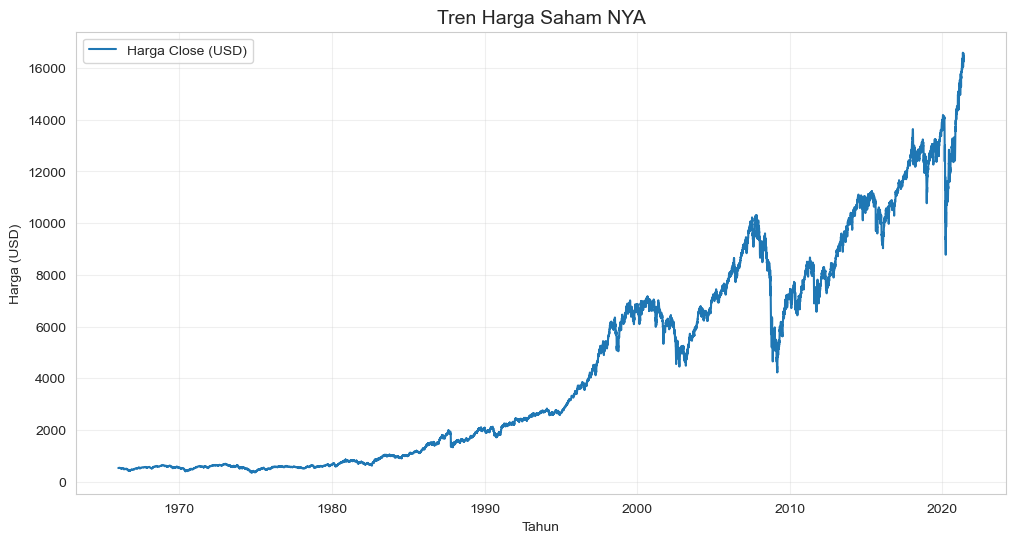

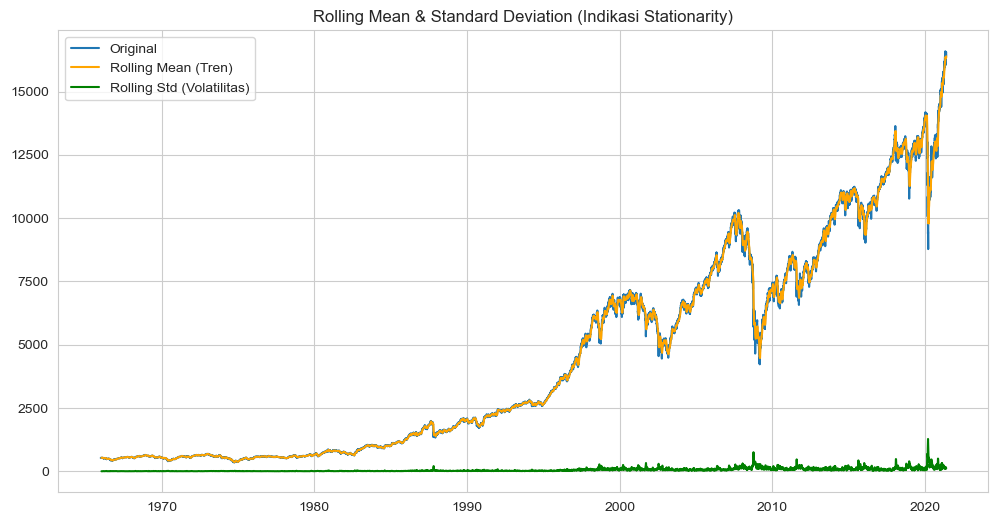

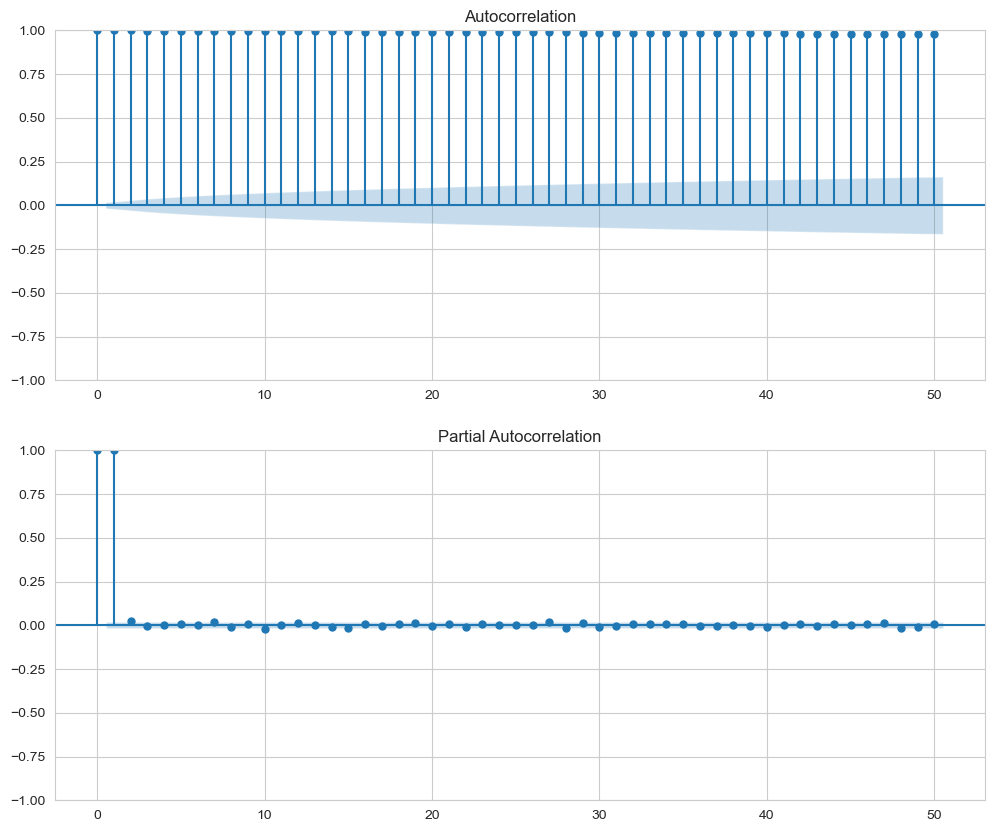

In [14]:
ticker = 'NYA'
data = df[df['Index'] == ticker].sort_values('Date').reset_index(drop=True)

# Visualisasi 1: Tren harga saham
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['CloseUSD'], label='Harga Close (USD)')
plt.title(f'Tren Harga Saham {ticker}', fontsize=14)
plt.xlabel('Tahun')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualisasi 2: Cek Stasioneritas dengan Rolling Mean & Standard Deviasi
rolling_mean = data['CloseUSD'].rolling(window=12).mean()
rolling_std = data['CloseUSD'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['CloseUSD'], label='Original')
plt.plot(data['Date'], rolling_mean, label='Rolling Mean (Tren)', color='orange')
plt.plot(data['Date'], rolling_std, label='Rolling Std (Volatilitas)', color='green')
plt.title('Rolling Mean & Standard Deviation (Indikasi Stationarity)')
plt.legend()
plt.show()

# Visualisasi 3: Autocorrelation (ACF) & Partial Autocorrelation (PACF)
# Tujuannya untuk menentukan "window size" (berapa hari ke belakang yang mempengaruhi hari ini)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(data['CloseUSD'], lags=50, ax=ax1) # Korelasi dengan hari-hari sebelumnya
plot_pacf(data['CloseUSD'], lags=50, ax=ax2) # Korelasi murni
plt.show()

**INSIGHT** 

VISUALISASI 1
- Grafik memiliki tren naik turun seiring waktu yang menandakan bahwa datanya non-stationary. ARIMA kurang bisa handle data seperti ini dan harus dilakukan differencing (mengurangi data hari ini dengan kemarin) berkali-kali hingga datanya stasioner / datar. Oleh karena itu, model yang lebih cocok digunakan untuk data ini adalah model LSTM yang lebih tahan banting terhadap data yang memiliki, namun perlu dilakukan normalisasi.

VISUALISASI 2
- rata-rata (garis kuning) dan standard deviasi (garis hijau) terlihat tidak bergerak stabil artinya data tidak stasioner (punya trend dan tidak stabil) dan volatilitas pasar berubah-ubah. Hal ini memperkuat alasan untuk membuang trend (proses differencing) sebelum menggunakan model ARIMA.

VISUALISASI 3
- grafik ACF (atas) terlihat memiliki pergerakan turun perlahan pada balok-balok biru yang menandakan bahwa harga hari ini sangat mirip dengan kemarin, harga kemarin mirip dengan kemarin lusa, dst. Hal ini mengonfirmasi bahwa data memiliki tren (non-stationary). 
- grafik PACF (bawah) menunjukkan bahwa harga saham sangat ditentukan oleh harga saham di 2 hari sebelumnya. Hal ini dapat dilihat dari dua balok di lag = 1 dan 2 yang sangat tinggi jika dibandingkan dengan lag lainnya yang cenderung stagnan.

### Uji Stationarity

In [15]:
def test_stationarity(timeseries, title):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'\n{title}')
    print('─' * 60)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretasi
    if result[1] <= 0.05:
        print(f"\n✓ STASIONER (p-value ≤ 0.05)")
        print(f"  Data TIDAK memiliki unit root, cocok untuk ARIMA")
    else:
        print(f"\n✗ NON-STASIONER (p-value > 0.05)")
        print(f"  Data memiliki unit root, perlu differencing")
    
    return result

# Test pada harga Close (level)
result_close = test_stationarity(data['Close'], 'HARGA CLOSE (Level)')

# Test pada first difference
data['Close_Diff'] = data['Close'].diff()
result_diff = test_stationarity(data['Close_Diff'], 'HARGA CLOSE (First Difference)')

print(f"""
{"="*70}
KESIMPULAN UJI STASIONERITAS:
{"="*70}
Harga Close dalam level adalah {'STASIONER' if result_close[1] <= 0.05 else 'NON-STASIONER'}.
Setelah differencing (d=1), data menjadi {'STASIONER' if result_diff[1] <= 0.05 else 'NON-STASIONER'}.

Implikasi untuk ARIMA:
- Parameter 'd' (differencing) yang optimal: {0 if result_close[1] <= 0.05 else 1}
- Model ARIMA harus menggunakan differencing untuk mengatasi trend
""")


HARGA CLOSE (Level)
────────────────────────────────────────────────────────────
ADF Statistic: 1.287155
p-value: 0.996536
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✗ NON-STASIONER (p-value > 0.05)
  Data memiliki unit root, perlu differencing

HARGA CLOSE (First Difference)
────────────────────────────────────────────────────────────
ADF Statistic: -17.487975
p-value: 0.000000
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✓ STASIONER (p-value ≤ 0.05)
  Data TIDAK memiliki unit root, cocok untuk ARIMA

KESIMPULAN UJI STASIONERITAS:
Harga Close dalam level adalah NON-STASIONER.
Setelah differencing (d=1), data menjadi STASIONER.

Implikasi untuk ARIMA:
- Parameter 'd' (differencing) yang optimal: 1
- Model ARIMA harus menggunakan differencing untuk mengatasi trend



### Visualisasi 5: Heatmap Korelasi Antar Fitur

**Jenis Plot**: Heatmap (Matrix Plot)

**JUSTIFIKASI**:
Heatmap adalah pilihan terbaik untuk visualisasi matrix korelasi karena:
1. Dapat menampilkan banyak variabel sekaligus (8+ kolom)
2. Color intensity langsung menunjukkan kekuatan korelasi
3. Mudah mengidentifikasi pola korelasi dalam satu pandangan

**AESTHETICS & MAPPING**:
1. X-axis & Y-axis (Position) → Feature Names (Categorical)
   Mapping: Setiap cell mewakili korelasi antara 2 fitur
   
2. Color (Intensity) → Correlation Coefficient (Continuous: -1 to +1)
   Mapping: Nilai korelasi dipetakan ke color gradient
   
3. Annotations (Text) → Exact correlation values

**PEMILIHAN WARNA (Continuous Diverging)**:
• RdYlGn (Red-Yellow-Green) dipilih karena:
  - RED (-1.0): Korelasi negatif sempurna
  - YELLOW (0.0): Tidak ada korelasi
  - GREEN (+1.0): Korelasi positif sempurna
  - Center=0: Warna diverging dari center point

Alasan Continuous Color: Karena correlation coefficient adalah nilai continuous dari -1 hingga +1, bukan kategori diskrit.

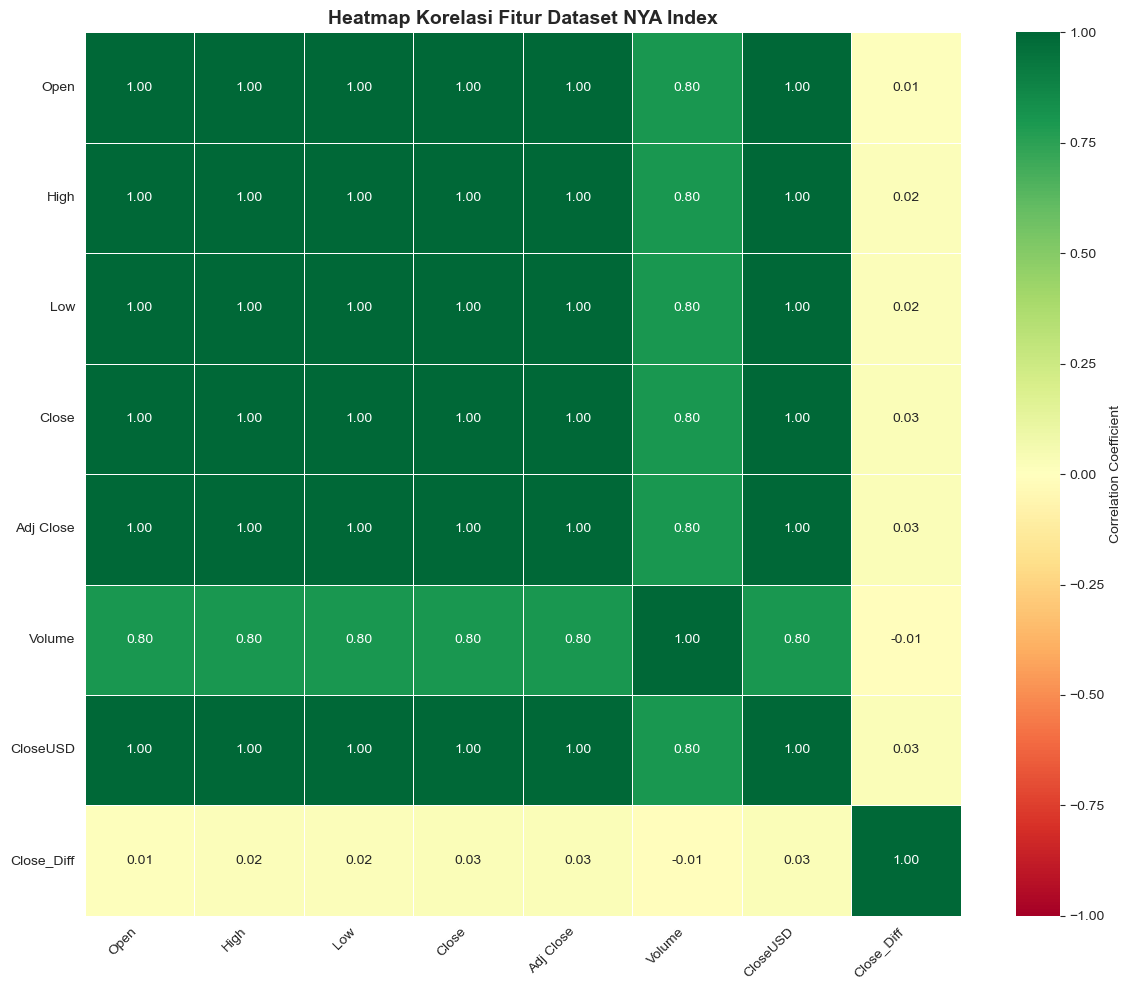

PASANGAN FITUR DENGAN KORELASI SANGAT TINGGI (>0.95):
────────────────────────────────────────────────────────────
• Open <-> High: 1.0000
• Open <-> Low: 0.9999
• Open <-> Close: 0.9999
• Open <-> Adj Close: 0.9999
• Open <-> CloseUSD: 0.9999
• High <-> Low: 0.9999
• High <-> Close: 0.9999
• High <-> Adj Close: 0.9999
• High <-> CloseUSD: 0.9999
• Low <-> Close: 1.0000
• Low <-> Adj Close: 1.0000
• Low <-> CloseUSD: 1.0000
• Close <-> Adj Close: 1.0000
• Close <-> CloseUSD: 1.0000
• Adj Close <-> CloseUSD: 1.0000


In [17]:
# Drop kolom non-numerik untuk korelasi
data_for_corr = data.drop(['Decade'], axis=1, errors='ignore')

plt.figure(figsize=(12, 10))

# Menghitung korelasi hanya untuk kolom numerik
corr_matrix = data_for_corr.corr(numeric_only=True)

# Membuat Heatmap dengan skema warna RdYlGn (Red-Yellow-Green)
sns.heatmap(corr_matrix,
            annot=True,
            cmap='RdYlGn',
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Heatmap Korelasi Fitur Dataset NYA Index', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Analisis korelasi tertinggi
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print("PASANGAN FITUR DENGAN KORELASI SANGAT TINGGI (>0.95):")
print("─" * 60)
for col1, col2, corr_val in high_corr_pairs:
    print(f"• {col1} <-> {col2}: {corr_val:.4f}")


**PENJELASAN:**
Open, High, Low, Close, dan Adj Close memiliki korelasi sangat tinggi (>0.99) karena mereka semua adalah harga saham pada hari yang sama:
- Open: Harga pembukaan
- High: Harga tertinggi hari itu
- Low: Harga terendah hari itu
- Close: Harga penutupan
- Adj Close: Close yang disesuaikan dengan corporate actions

Korelasi sempurna ini NORMAL dan EXPECTED dalam data stock market.

Volume biasanya memiliki korelasi lebih rendah dengan harga karena:
- Volume adalah jumlah saham yang diperdagangkan
- Tidak selalu bergerak searah dengan harga
- High volume bisa terjadi saat harga naik ATAU turun

**IMPLIKASI UNTUK MODELING**:
- Untuk prediksi, cukup gunakan satu fitur harga (Close) karena redundansi tinggi
- Volume bisa ditambahkan sebagai feature engineering jika diperlukan
- Multicollinearity tidak masalah untuk LSTM, tapi bisa jadi issue untuk linear models

## Preprocessing & Training Model

### Data Untuk LSTM

In [18]:
# --- 3. DATA PREPROCESSING FOR LSTM ---

# A. Normalisasi (Wajib untuk Neural Network)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['CloseUSD'].values.reshape(-1, 1))

# B. Membuat Struktur Data Time Series (X=60 hari lalu, y=Hari ini)
def create_dataset(dataset, time_step=60):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0] # Ambil 60 hari
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0]) # Ambil hari ke-61 sebagai target
    return np.array(data_X), np.array(data_Y)

time_step = 60 # Kita pakai 60 hari ke belakang untuk prediksi besok
X, y = create_dataset(scaled_data, time_step)

# C. Train-Test Split (urut, tidak di-shuffle)
training_size = int(len(X) * 0.80)
test_size = len(X) - training_size

X_train, X_test = X[0:training_size], X[training_size:len(X)]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

# Reshape input untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

# --- 4. MEMBANGUN MODEL LSTM ---

model = Sequential()

# Layer 1: LSTM + Return Sequences=True (karena kita akan tumpuk LSTM lagi)
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2)) # Matikan 20% neuron secara acak (Mencegah Overfit)

# Layer 2: LSTM + Return Sequences=False (Layer terakhir LSTM)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer Output: Prediksi 1 harga (Close Price)
model.add(Dense(units=1)) # 1 Neuron output

model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping
# Jika 'val_loss' tidak membaik selama 5 epoch, stop training.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, # Set agak tinggi, nanti dipotong EarlyStopping
    batch_size=32,
    callbacks=[early_stop], # Pasang penjaga overfit disini
    verbose=1
)

Shape X_train: (11108, 60, 1)
Shape X_test: (2778, 60, 1)
Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 4.0562e-04 - val_loss: 6.6328e-04
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 3.3691e-04 - val_loss: 9.7648e-04
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 3.2353e-04 - val_loss: 4.1939e-04
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 2.7284e-04 - val_loss: 0.0011
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 2.6447e-04 - val_loss: 0.0013
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 2.3832e-04 - val_loss: 4.1535e-04
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 2.3688e-04 - val_loss: 8.5787e-04
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 2.3276e-04 - val_loss: 2.0076e-04
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 2.2815e-04 - val_loss: 4.2437e-

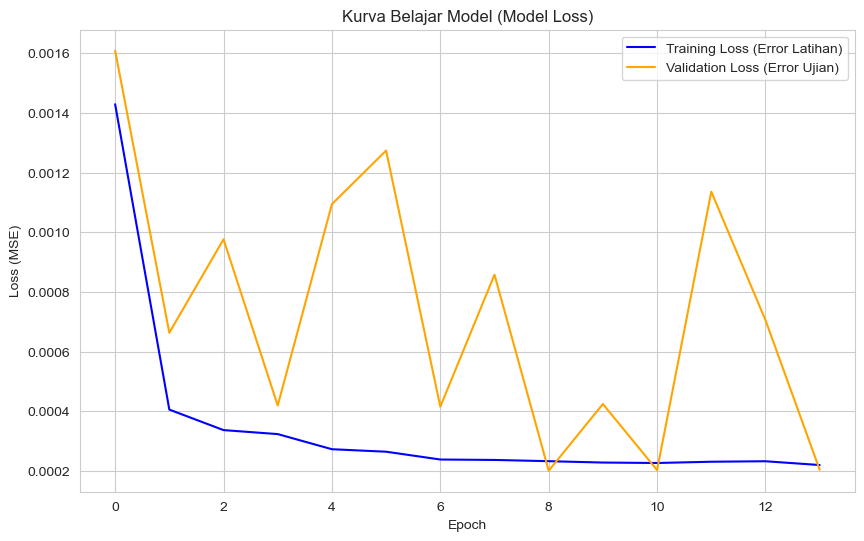

348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE Score (Error Rata-rata dalam USD): 230.14


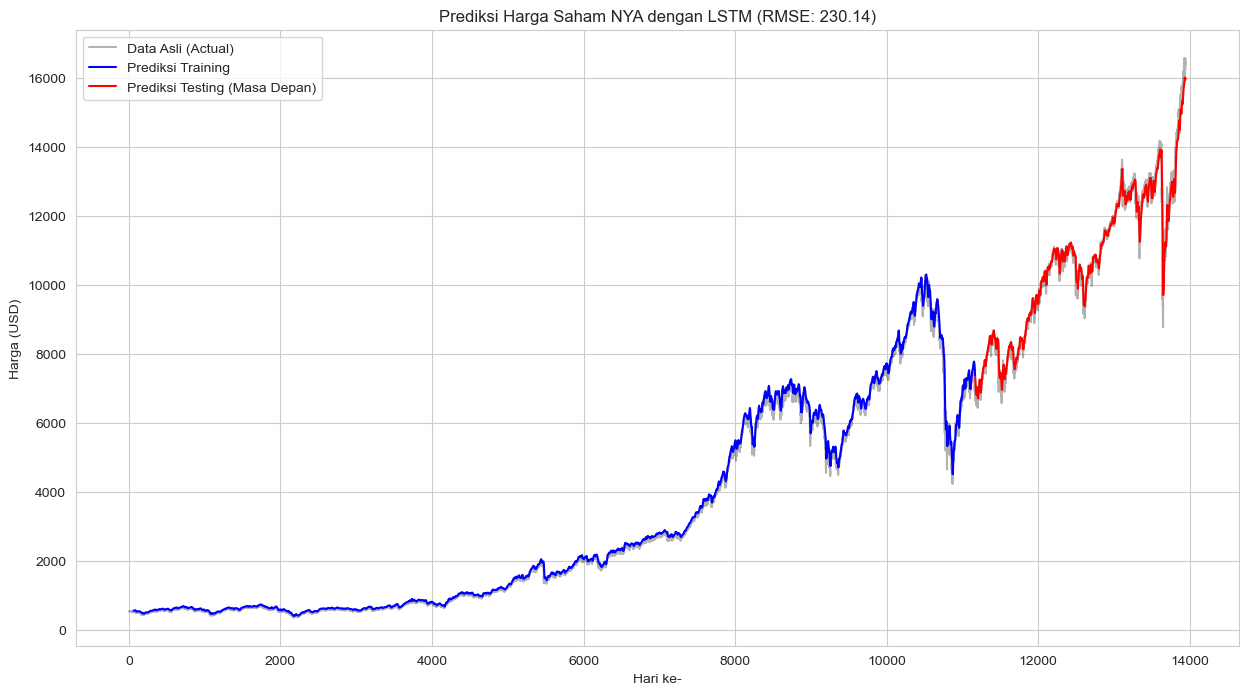

In [ ]:
# --- 5. EVALUASI HASIL & DETEKSI OVERFITTING ---

# A. Plot Loss Training vs Validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (Error Latihan)', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss (Error Ujian)', color='orange')
plt.title('Kurva Belajar Model (Model Loss)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


# --- 6. PREDIKSI FINAL & VISUALISASI ---

# 1. Prediksi data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 2. Kembalikan ke skala asli (Inverse Transform)
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# 3. Hitung RMSE
import math
from sklearn.metrics import mean_squared_error
rmse_score = math.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print(f"RMSE Score (Error Rata-rata dalam USD): {rmse_score:.2f}")

# 4. Siapkan Array untuk Plotting (Isi dengan NaN dulu)
# Tujuannya agar grafik tidak tersambung garis lurus antara train dan test
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan

# 5. Isi Array dengan Data Prediksi
# -- Plot Training --
# Training dimulai setelah 'time_step' (karena 60 data awal dipakai untuk memprediksi data ke-61)
train_start_idx = time_step
train_end_idx = train_start_idx + len(train_predict)
trainPredictPlot[train_start_idx:train_end_idx, :] = train_predict

# -- Plot Testing --
# Testing dimulai tepat setelah Training berakhir
test_start_idx = train_end_idx
test_end_idx = test_start_idx + len(test_predict)

# Masukkan data (Pastikan tidak melebihi panjang array asli)
# Gunakan slicing yang fleksibel agar tidak error
testPredictPlot[test_start_idx:test_end_idx, :] = test_predict

# 6. Tampilkan Grafik
plt.figure(figsize=(15, 8))
# Plot Data Asli (Hitam)
plt.plot(scaler.inverse_transform(scaled_data), label='Data Asli (Actual)', color='black', alpha=0.3)
# Plot Hasil Training (Biru)
plt.plot(trainPredictPlot, label='Prediksi Training', color='blue')
# Plot Hasil Testing (Merah)
plt.plot(testPredictPlot, label='Prediksi Testing (Masa Depan)', color='red')

plt.title(f'Prediksi Harga Saham {ticker} dengan LSTM (RMSE: {rmse_score:.2f})')
plt.xlabel('Hari ke-')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()



**INTERPRETASI**
Garis kuning naik turun drastis artinya model overfitting. Adanya gap antara training dan validation loss yang besar menandakan model menghafal training data tapi gagal generalize. 

Total data points: 13947
Date range: 1965-12-31 00:00:00 to 2021-05-28 00:00:00
Using 14 features: ['CloseUSD', 'Open', 'High', 'Low', 'Volume', 'Price_Change', 'High_Low_Range', 'MA_7', 'MA_21', 'MA_50', 'Volatility', 'Close_Lag_1', 'Close_Lag_7', 'Volume_MA']
X shape: (13837, 60, 14)
y shape: (13837,)

Data split:
Train: 9685 samples (70.0%)
Val:   2075 samples (15.0%)
Test:  2077 samples (15.0%)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,817 (401.63 KB)

 Trainable params: 102,817 (401.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training model...
Epoch 1/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - loss: 0.0010 - mae: 0.0267 - val_loss: 8.3263e-04 - val_mae: 0.0355 - learning_rate: 0.0010
Epoch 2/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 5.1738e-04 - mae: 0.0212 - val_loss: 7.2458e-04 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 3/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 4.7661e-04 - mae: 0.0212 - val_loss: 0.0018 - val_mae: 0.0562 - learning_rate: 0.0010
Epoch 4/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 4.4007e-04 - mae: 0.0204 - val_loss: 7.3267e-04 - val_mae: 0.0325 - learning_rate: 0.0010
Epoch 5/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 4.2303e-04 - mae: 0.0201 - val_loss: 5.1182e-04 - val_mae: 0.0274 - learning_rate: 0.0010
Epoch 6/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 4.1412e-04 - mae: 0.0200 - val_loss: 8.7394e-04 - val_mae: 0.0368 - learning_rate: 0.0010
Epoch 7/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - loss: 4.0614

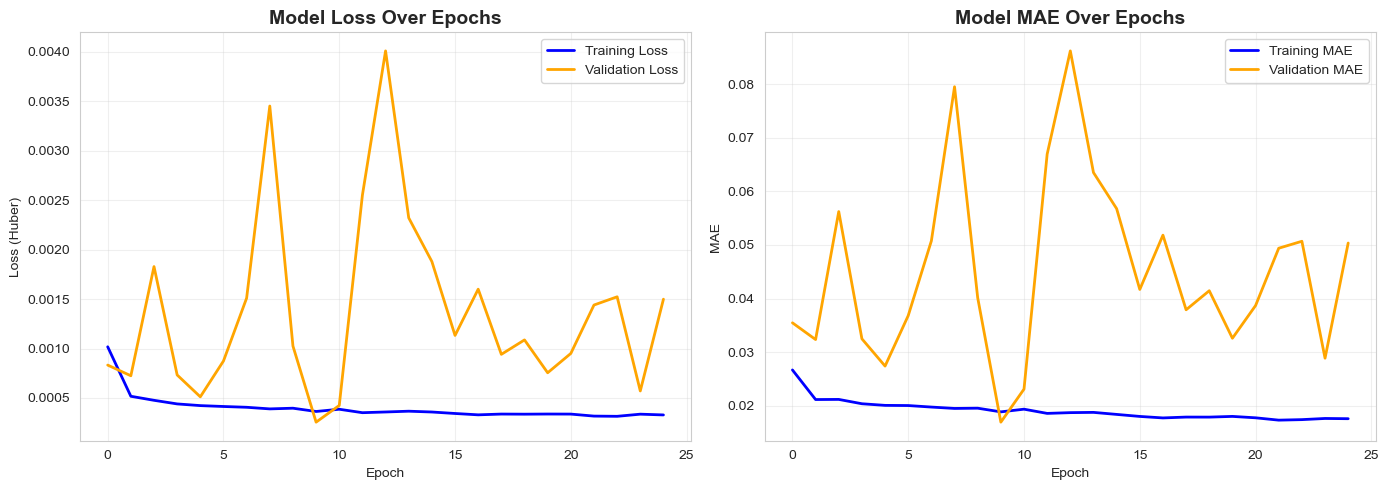


✅ Saved: lstm_training_history.png


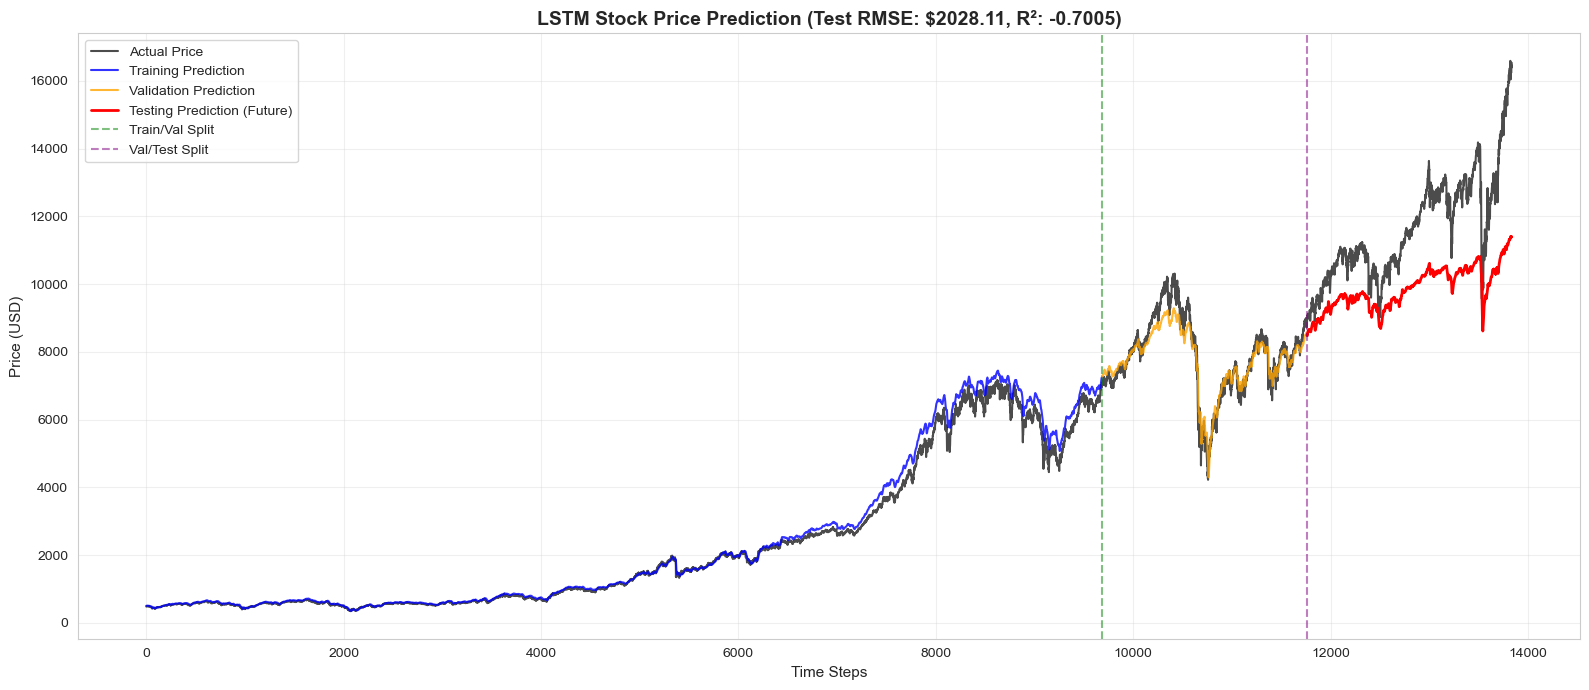

✅ Saved: lstm_prediction_full.png


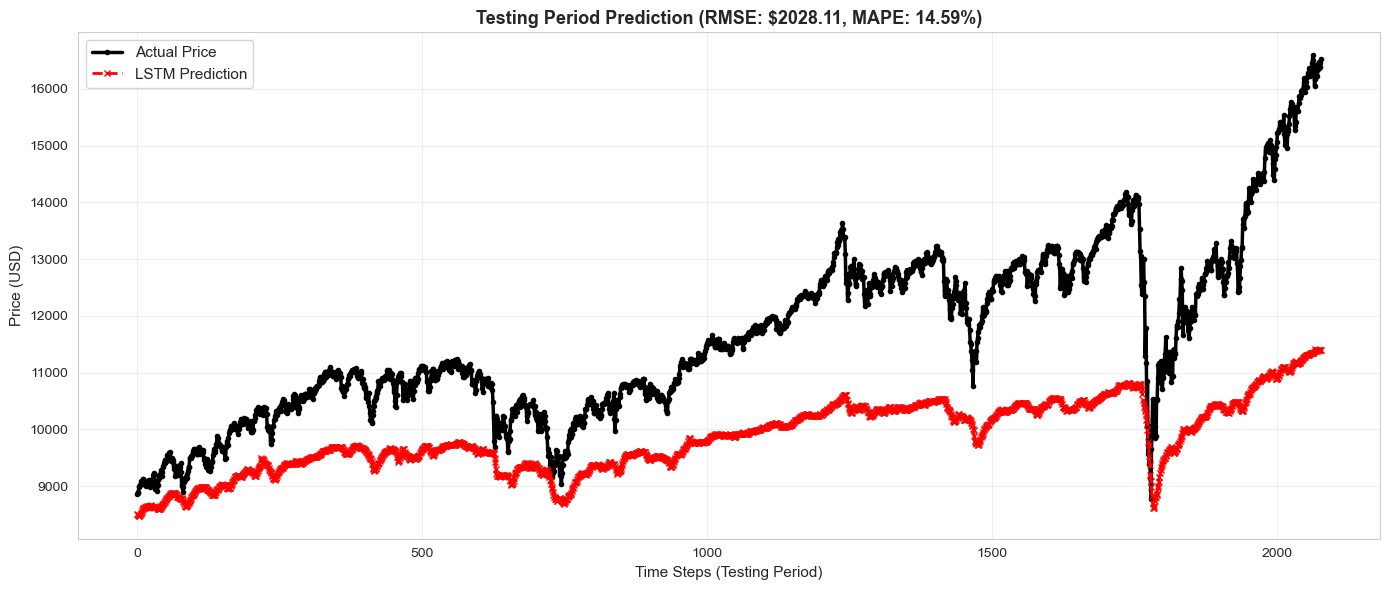

✅ Saved: lstm_prediction_test_only.png


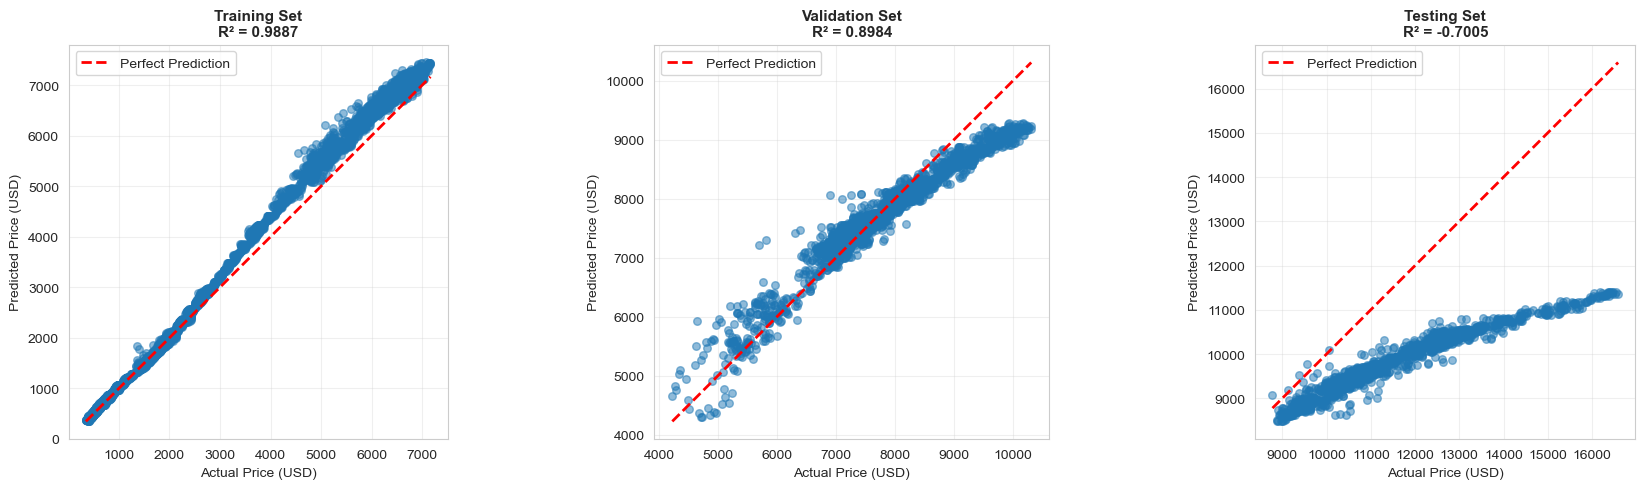

✅ Saved: lstm_scatter_plots.png

📊 FINAL MODEL EVALUATION SUMMARY

✅ Best Metrics (Testing Set):
   RMSE:  $2028.11
   MAE:   $1787.65
   R²:    -0.7005
   MAPE:  14.59%

📈 Model Performance:
   🔴 NEEDS IMPROVEMENT - Consider more tuning

🎯 Generalization Check:
   Training R²:   0.9887
   Validation R²: 0.8984
   Testing R²:    -0.7005
   ❌ Overfitting detected - Model needs regularization

All visualizations saved! Check your directory.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import math

# ==========================================
# 1. LOAD DATA
# ==========================================
# Ganti dengan path file kamu
data = pd.read_csv("../dataset/indexProcessed.csv")
data = data[data['Index'] == 'NYA'].copy()  # Filter NYA
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

print(f"Total data points: {len(data)}")
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")

# ==========================================
# 2. FEATURE ENGINEERING (PENTING!)
# ==========================================
# Jangan hanya pakai Close! Tambahkan features untuk capture pattern

# Price features
data['Price_Change'] = data['CloseUSD'] - data['Open']
data['High_Low_Range'] = data['High'] - data['Low']

# Moving Averages
data['MA_7'] = data['CloseUSD'].rolling(window=7).mean()
data['MA_21'] = data['CloseUSD'].rolling(window=21).mean()
data['MA_50'] = data['CloseUSD'].rolling(window=50).mean()

# Volatility
data['Daily_Return'] = data['CloseUSD'].pct_change()
data['Volatility'] = data['Daily_Return'].rolling(window=10).std()

# Lag features
data['Close_Lag_1'] = data['CloseUSD'].shift(1)
data['Close_Lag_7'] = data['CloseUSD'].shift(7)

# Volume features
data['Volume_MA'] = data['Volume'].rolling(window=7).mean()

# Drop NaN
data = data.dropna().reset_index(drop=True)

# Select features untuk model
features = ['CloseUSD', 'Open', 'High', 'Low', 'Volume',
            'Price_Change', 'High_Low_Range', 'MA_7', 'MA_21', 'MA_50',
            'Volatility', 'Close_Lag_1', 'Close_Lag_7', 'Volume_MA']

data_features = data[features].values
print(f"Using {len(features)} features: {features}")

# ==========================================
# 3. NORMALISASI (MinMaxScaler)
# ==========================================
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_features)

# ==========================================
# 4. CREATE TIME SERIES DATASET
# ==========================================
def create_dataset(dataset, time_step=60):
    """
    Create sequences for LSTM
    X = [time_step previous observations]
    y = [next value of CloseUSD]
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # All features
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0])  # Target = CloseUSD (index 0)
    return np.array(data_X), np.array(data_Y)

# Gunakan 60 hari lookback
time_step = 60
X, y = create_dataset(scaled_data, time_step)

print(f"X shape: {X.shape}")  # (samples, time_step, features)
print(f"y shape: {y.shape}")  # (samples,)

# ==========================================
# 5. TRAIN-TEST-VALIDATION SPLIT
# ==========================================
# IMPORTANT: Bagi jadi 3 parts untuk better evaluation
train_size = int(len(X) * 0.70)  # 70% training
val_size = int(len(X) * 0.15)    # 15% validation
test_size = len(X) - train_size - val_size  # 15% testing

X_train = X[0:train_size]
y_train = y[0:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"\nData split:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# ==========================================
# 6. BUILD IMPROVED LSTM MODEL
# ==========================================
def build_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential([
        # Layer 1: Bidirectional LSTM (tangkap pola dari 2 arah)
        Bidirectional(LSTM(units=64, return_sequences=True), 
                     input_shape=input_shape),
        Dropout(0.3),  # Dropout lebih tinggi untuk prevent overfitting
        
        # Layer 2: LSTM
        LSTM(units=64, return_sequences=True),
        Dropout(0.3),
        
        # Layer 3: LSTM
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        
        # Dense layers
        Dense(units=16, activation='relu'),
        Dropout(0.2),
        
        # Output layer
        Dense(units=1)
    ])
    
    # Custom optimizer dengan learning rate lebih kecil
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])
    # Huber loss lebih robust terhadap outliers dibanding MSE
    
    return model

model = build_lstm_model(input_shape=(time_step, X_train.shape[2]))
model.summary()

# ==========================================
# 7. CALLBACKS (ANTI-OVERFITTING!)
# ==========================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Lebih sabar
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi LR jadi setengahnya
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# ==========================================
# 8. TRAINING
# ==========================================
print("\n🚀 Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==========================================
# 9. EVALUATION
# ==========================================
print("\n📊 Evaluating model...")

# Predictions
train_predict = model.predict(X_train, verbose=0)
val_predict = model.predict(X_val, verbose=0)
test_predict = model.predict(X_test, verbose=0)

# Inverse transform untuk kembalikan ke skala asli
# Buat dummy array dengan ukuran sama seperti scaled_data columns
def inverse_scale_target(predictions, original_scaler, n_features):
    """Inverse transform hanya untuk target (CloseUSD)"""
    dummy = np.zeros((len(predictions), n_features))
    dummy[:, 0] = predictions.flatten()  # CloseUSD di index 0
    return original_scaler.inverse_transform(dummy)[:, 0]

train_predict_inv = inverse_scale_target(train_predict, scaler, len(features))
val_predict_inv = inverse_scale_target(val_predict, scaler, len(features))
test_predict_inv = inverse_scale_target(test_predict, scaler, len(features))

# Inverse transform untuk y actual
y_train_inv = inverse_scale_target(y_train.reshape(-1, 1), scaler, len(features))
y_val_inv = inverse_scale_target(y_val.reshape(-1, 1), scaler, len(features))
y_test_inv = inverse_scale_target(y_test.reshape(-1, 1), scaler, len(features))

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{set_name} Metrics:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

train_metrics = calculate_metrics(y_train_inv, train_predict_inv, "Training")
val_metrics = calculate_metrics(y_val_inv, val_predict_inv, "Validation")
test_metrics = calculate_metrics(y_test_inv, test_predict_inv, "Testing")

# Overfitting check
print(f"\n🔍 Overfitting Analysis:")
train_test_gap = train_metrics['r2'] - test_metrics['r2']
print(f"  R² Gap (Train - Test): {train_test_gap:.4f}")

if train_test_gap > 0.15:
    print("  ⚠️ OVERFITTING DETECTED!")
elif train_test_gap > 0.05:
    print("  ⚠️ Slight overfitting")
else:
    print("  ✅ Good generalization!")

# ==========================================
# 10. VISUALIZATIONS
# ==========================================

# Plot 1: Training History (Loss)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
plt.title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: lstm_training_history.png")

# Plot 2: Predictions vs Actual (Full Timeline)
plt.figure(figsize=(16, 7))

# Prepare full timeline
full_actual = np.concatenate([y_train_inv, y_val_inv, y_test_inv])
full_pred = np.concatenate([train_predict_inv, val_predict_inv, test_predict_inv])

train_end = len(y_train_inv)
val_end = train_end + len(y_val_inv)

# Plot
plt.plot(range(len(full_actual)), full_actual, 
         label='Actual Price', color='black', linewidth=1.5, alpha=0.7)
plt.plot(range(train_end), train_predict_inv, 
         label='Training Prediction', color='blue', linewidth=1.5, alpha=0.8)
plt.plot(range(train_end, val_end), val_predict_inv, 
         label='Validation Prediction', color='orange', linewidth=1.5, alpha=0.8)
plt.plot(range(val_end, len(full_actual)), test_predict_inv, 
         label='Testing Prediction (Future)', color='red', linewidth=2)

# Vertical lines untuk split points
plt.axvline(x=train_end, color='green', linestyle='--', alpha=0.5, label='Train/Val Split')
plt.axvline(x=val_end, color='purple', linestyle='--', alpha=0.5, label='Val/Test Split')

plt.title(f'LSTM Stock Price Prediction (Test RMSE: ${test_metrics["rmse"]:.2f}, R²: {test_metrics["r2"]:.4f})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=11)
plt.ylabel('Price (USD)', fontsize=11)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_prediction_full.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: lstm_prediction_full.png")

# Plot 3: Zoom in pada Testing Period
plt.figure(figsize=(14, 6))
test_length = len(y_test_inv)
plt.plot(range(test_length), y_test_inv, 
         label='Actual Price', color='black', linewidth=2.5, marker='o', markersize=3)
plt.plot(range(test_length), test_predict_inv, 
         label='LSTM Prediction', color='red', linewidth=2, linestyle='--', marker='x', markersize=4)

plt.title(f'Testing Period Prediction (RMSE: ${test_metrics["rmse"]:.2f}, MAPE: {test_metrics["mape"]:.2f}%)', 
          fontsize=13, fontweight='bold')
plt.xlabel('Time Steps (Testing Period)', fontsize=11)
plt.ylabel('Price (USD)', fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_prediction_test_only.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: lstm_prediction_test_only.png")

# Plot 4: Scatter Plot (Predicted vs Actual)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, title, metrics_dict) in enumerate([
    (y_train_inv, train_predict_inv, 'Training Set', train_metrics),
    (y_val_inv, val_predict_inv, 'Validation Set', val_metrics),
    (y_test_inv, test_predict_inv, 'Testing Set', test_metrics)
]):
    ax = axes[idx]
    ax.scatter(y_true, y_pred, alpha=0.5, s=30)
    
    # Perfect prediction line
    min_val, max_val = y_true.min(), y_true.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Price (USD)', fontsize=10)
    ax.set_ylabel('Predicted Price (USD)', fontsize=10)
    ax.set_title(f'{title}\nR² = {metrics_dict["r2"]:.4f}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('lstm_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: lstm_scatter_plots.png")

# ==========================================
# 11. FINAL SUMMARY
# ==========================================
print("\n" + "="*60)
print("📊 FINAL MODEL EVALUATION SUMMARY")
print("="*60)

print(f"\n✅ Best Metrics (Testing Set):")
print(f"   RMSE:  ${test_metrics['rmse']:.2f}")
print(f"   MAE:   ${test_metrics['mae']:.2f}")
print(f"   R²:    {test_metrics['r2']:.4f}")
print(f"   MAPE:  {test_metrics['mape']:.2f}%")

print(f"\n📈 Model Performance:")
if test_metrics['r2'] > 0.85:
    print("   🟢 EXCELLENT - Model follows trend very well!")
elif test_metrics['r2'] > 0.70:
    print("   🟡 GOOD - Model performs reasonably well")
else:
    print("   🔴 NEEDS IMPROVEMENT - Consider more tuning")

print(f"\n🎯 Generalization Check:")
print(f"   Training R²:   {train_metrics['r2']:.4f}")
print(f"   Validation R²: {val_metrics['r2']:.4f}")
print(f"   Testing R²:    {test_metrics['r2']:.4f}")

if train_test_gap < 0.05:
    print("   ✅ Excellent generalization - No overfitting!")
elif train_test_gap < 0.15:
    print("   ⚠️ Acceptable - Slight overfitting")
else:
    print("   ❌ Overfitting detected - Model needs regularization")

print("\n" + "="*60)
print("All visualizations saved! Check your directory.")
print("="*60)